In [175]:
# Essential Libraries
import pandas as pd
import numpy as np

# Data Preprocessing and Transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


In [176]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])

In [177]:
# Extract date features
for df in [train, test]:
    df['Policy_Month'] = df['Policy Start Date'].dt.month
    df['Policy_Year'] = df['Policy Start Date'].dt.year
    df['Policy_Day'] = df['Policy Start Date'].dt.day
    df['Policy_DayOfWeek'] = df['Policy Start Date'].dt.dayofweek

In [178]:
# 2. Handle categorical variables
categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 
                      'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 
                      'Exercise Frequency', 'Property Type']

# Label encode categorical variables
le_dict = {}
for col in categorical_columns:
    le_dict[col] = LabelEncoder()
    if col in train.columns:
        train[col] = train[col].fillna('Missing')
        test[col] = test[col].fillna('Missing')
        le_dict[col].fit(list(train[col].unique()) + list(test[col].unique()))
        train[col] = le_dict[col].transform(train[col])
        test[col] = le_dict[col].transform(test[col])


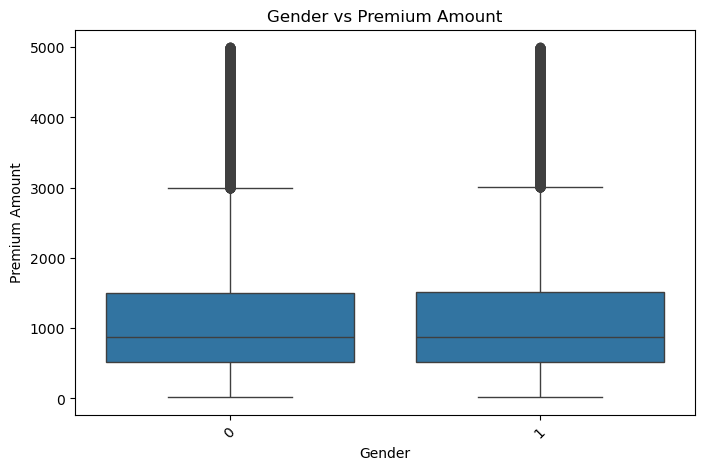

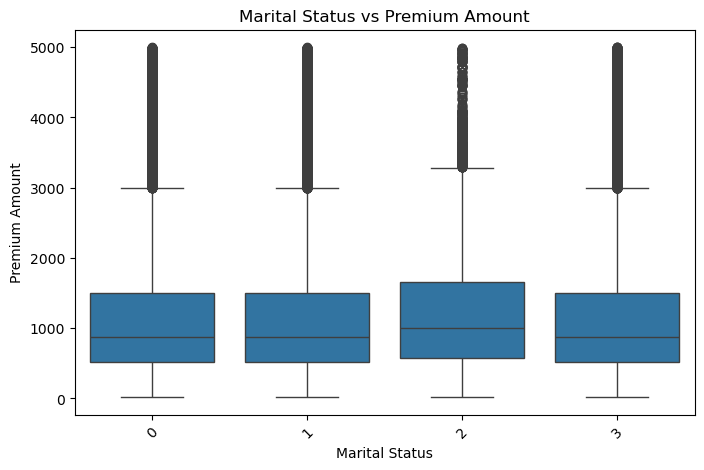

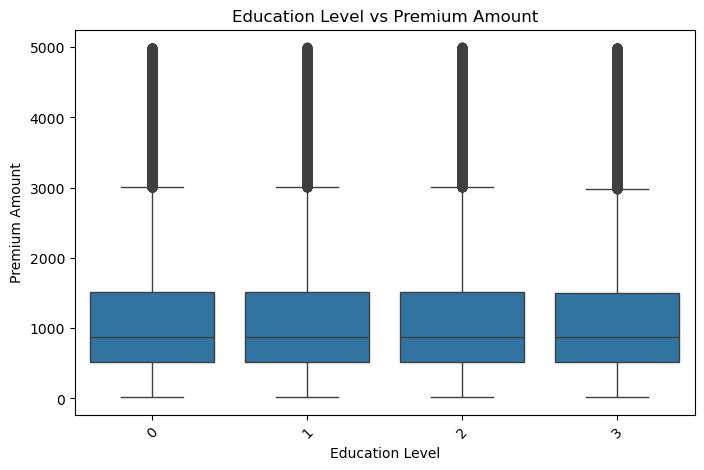

In [ ]:
# Boxplots for categorical variables vs target variable
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train, x=col, y='Premium Amount')
    plt.title(f"{col} vs Premium Amount")
    plt.xlabel(col)
    plt.ylabel("Premium Amount")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# Correlation matrix
corr_columns = categorical_columns + ['Premium Amount']

# Compute the correlation matrix
corr_matrix = train[corr_columns].corr()

# Visualize the heatmap including 'Premium Amount'
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Correlation Heatmap Including Premium Amount")
plt.show()


In [ ]:
train_clean = train.copy()
train_clean = train_clean.replace([np.inf, -np.inf], np.nan)
train_clean = train_clean.dropna(subset=['Health Score', 'Premium Amount', 'Age', 'Number of Dependents', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'])

In [ ]:
# List of numerical columns
numerical_cols = ['Age', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

# Create empty dictionary to store direct correlations with Premium Amount
direct_correlations = {}

# Calculate direct correlations for numerical columns
for col in numerical_cols:
    correlation = pearsonr(train_clean[col], train_clean['Premium Amount'])[0]
    direct_correlations[col] = correlation

# Convert to DataFrame for better visualization
direct_correlations_df = pd.DataFrame(list(direct_correlations.items()), columns=['Feature', 'Correlation'])
direct_correlations_df = direct_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Direct Correlations with Premium Amount:")
print(direct_correlations_df)

# Create visualization of correlations
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Feature', data=direct_correlations_df, palette='viridis')
plt.title('Direct Correlations of Features with Premium Amount')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
# Separate the data by Smoking Status
non_smokers = train_clean[train_clean['Smoking Status'] == 0]
smokers = train_clean[train_clean['Smoking Status'] == 1]

# Calculate correlations
correlation_non_smokers = non_smokers['Health Score'].corr(non_smokers['Premium Amount'])
correlation_smokers = smokers['Health Score'].corr(smokers['Premium Amount'])

print(f"Correlation between Health Score and Premium Amount for Non-Smokers: {correlation_non_smokers:.5f}")
print(f"Correlation between Health Score and Premium Amount for Smokers: {correlation_smokers:.5f}")

# Visualization
plt.figure(figsize=(12, 6))

# Scatter plot for non-smokers
plt.subplot(1, 2, 1)
sns.scatterplot(x=non_smokers['Health Score'], y=non_smokers['Premium Amount'])
plt.title(f"Non-Smokers: Correlation = {correlation_non_smokers:.5f}")
plt.xlabel("Health Score")
plt.ylabel("Premium Amount")

# Scatter plot for smokers
plt.subplot(1, 2, 2)
sns.scatterplot(x=smokers['Health Score'], y=smokers['Premium Amount'])
plt.title(f"Smokers: Correlation = {correlation_smokers:.5f}")
plt.xlabel("Health Score")
plt.ylabel("Premium Amount")

plt.tight_layout()
plt.show()

In [ ]:
# Separate the data by Smoking Status
male = train_clean[train_clean['Gender'] == 0]
female = train_clean[train_clean['Gender'] == 1]

# Calculate correlations
correlation_male = male['Health Score'].corr(male['Premium Amount'])
correlation_female = female['Health Score'].corr(female['Premium Amount'])

print(f"Correlation between Health Score and Premium Amount for Males: {correlation_male:.5f}")
print(f"Correlation between Health Score and Premium Amount for Females: {correlation_female:.5f}")

# Visualization
plt.figure(figsize=(12, 6))

# Scatter plot for non-smokers
plt.subplot(1, 2, 1)
sns.scatterplot(x=male['Health Score'], y=male['Premium Amount'])
plt.title(f"Non-Smokers: Correlation = {correlation_non_smokers:.5f}")
plt.xlabel("Health Score")
plt.ylabel("Premium Amount")

# Scatter plot for smokers
plt.subplot(1, 2, 2)
sns.scatterplot(x=female['Health Score'], y=female['Premium Amount'])
plt.title(f"Smokers: Correlation = {correlation_smokers:.5f}")
plt.xlabel("Health Score")
plt.ylabel("Premium Amount")

plt.tight_layout()
plt.show()

In [ ]:
# Create the interactive term
train['Smoking_Health_Interaction'] = (train['Smoking Status']+1) * train['Health Score']**2
test['Smoking_Health_Interaction'] = (test['Smoking Status']+1) * test['Health Score']**2

# Analyze the correlation with Premium Amount
interaction_corr = train['Smoking_Health_Interaction'].corr(train['Premium Amount'])
print(f"Correlation between Smoking_Health_Interaction and Premium Amount: {interaction_corr:.5f}")


plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['Smoking_Health_Interaction'], y=train['Premium Amount'])
plt.title(f"Smoking_Health_Interaction vs Premium Amount\nCorrelation = {interaction_corr:.5f}")
plt.xlabel("Smoking_Health_Interaction")
plt.ylabel("Premium Amount")
plt.show()


In [ ]:
# Create the interactive term
train['Gender_Health_Interaction'] = (train['Gender'] + 1) * train['Health Score'] ** 2
test['Gender_Health_Interaction'] = (test['Gender'] + 1) * test['Health Score'] ** 2

# Analyze the correlation with Premium Amount
interaction_corr = train['Gender_Health_Interaction'].corr(train['Premium Amount'])
print(f"Correlation between Gender_Health_Interaction and Premium Amount: {interaction_corr:.5f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['Gender_Health_Interaction'], y=train['Premium Amount'])
plt.title(f"Gender_Health_Interaction vs Premium Amount\nCorrelation = {interaction_corr:.5f}")
plt.xlabel("Gender_Health_Interaction")
plt.ylabel("Premium Amount")
plt.show()

In [ ]:
# Create the interactive term including Smoker
train['Exercise_Smoker_Health_Interaction'] = (train['Exercise Frequency'] + 1) * train['Health Score'] ** 2 * (train['Smoking Status'] + 1)
test['Exercise_Smoker_Health_Interaction'] = (test['Exercise Frequency'] + 1) * test['Health Score'] ** 2 * (test['Smoking Status'] + 1)

# Analyze the correlation with Premium Amount
interaction_corr = train['Exercise_Smoker_Health_Interaction'].corr(train['Premium Amount'])
print(f"Correlation between Exercise_Smoker_Health_Interaction and Premium Amount: {interaction_corr:.5f}")


plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['Exercise_Smoker_Health_Interaction'], y=train['Premium Amount'])
plt.title(f"Exercise_Smoker_Health_Interaction vs Premium Amount\nCorrelation = {interaction_corr:.5f}")
plt.xlabel("Exercise_Smoker_Health_Interaction")
plt.ylabel("Premium Amount")
plt.show()

In [ ]:
# Create the interactive term
train['Smoking_Age_Health_Interaction'] = (train['Smoking Status']+1) * train['Health Score']**2 / train['Age']**(1/2)
test['Smoking_Age_Health_Interaction'] = (test['Smoking Status']+1) * test['Health Score']**2 / test['Age']**(1/2)

# Analyze the correlation with Premium Amount
interaction_corr = train['Smoking_Age_Health_Interaction'].corr(train['Premium Amount'])
print(f"Correlation between Smoking_Age_Health_Interaction and Premium Amount: {interaction_corr:.5f}")


plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['Smoking_Age_Health_Interaction'], y=train['Premium Amount'])
plt.title(f"Smoking_Age_Health_Interaction vs Premium Amount\nCorrelation = {interaction_corr:.5f}")
plt.xlabel("Smoking_Age_Health_Interaction")
plt.ylabel("Premium Amount")
plt.show()

In [ ]:
# Create the interactive term
train['Smoking_Age_Gender_Health_Interaction'] = (
    (train['Smoking Status'] + 1) * (train['Gender'] + 1) * train['Health Score']**2 / train['Age']**(1/2)
)
test['Smoking_Age_Gender_Health_Interaction'] = (
    (test['Smoking Status'] + 1) * (test['Gender'] + 1) * test['Health Score']**2 / test['Age']**(1/2)
)

# Analyze the correlation with Premium Amount
interaction_corr = train['Smoking_Age_Gender_Health_Interaction'].corr(train['Premium Amount'])
print(f"Correlation between Smoking_Age_Gender_Health_Interaction and Premium Amount: {interaction_corr:.5f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['Smoking_Age_Gender_Health_Interaction'], y=train['Premium Amount'])
plt.title(f"Smoking_Age_Gender_Health_Interaction vs Premium Amount\nCorrelation = {interaction_corr:.5f}")
plt.xlabel("Smoking_Age_Gender_Health_Interaction")
plt.ylabel("Premium Amount")
plt.show()


In [ ]:
from itertools import permutations, product

# Parameters to consider
parameters = ['Smoking Status', 'Gender', 'Health Score', 'Age']
operations = ['*', '/']  # Multiplication and Division

# Generate all permutations of parameters
param_permutations = list(permutations(parameters))

# Generate all combinations of operations for a given number of parameters
operation_combinations = list(product(operations, repeat=len(parameters) - 1))

# Function to evaluate the formula as specified
def evaluate_formula(df, params, ops):
    result = (df[params[0]] + 1)  # Start with the first parameter (add 1)
    for i, op in enumerate(ops):
        if params[i + 1] == 'Health Score':
            current_value = df[params[i + 1]] ** 2  # Square Health Score
        elif params[i + 1] == 'Age':
            current_value = df[params[i + 1]] ** 0.5  # Square root of Age
        else:
            current_value = df[params[i + 1]] + 1  # Add 1 for Smoking Status and Gender

        if op == '*':
            result = result * current_value
        elif op == '/':
            # Handle division by zero
            result = result / (current_value + 1e-10)
    return result

# Find the best combination
best_combination = None
best_correlation = -float('inf')

# Iterate over all permutations of parameters and operation combinations
for params in param_permutations:
    for ops in operation_combinations:
        # Evaluate the formula
        train['Interaction_Term'] = evaluate_formula(train, params, ops)
        
        # Calculate the correlation
        corr = train['Interaction_Term'].corr(train['Premium Amount'])
        
        # Store the best combination
        if corr > best_correlation:
            best_combination = (params, ops)
            best_correlation = corr

        print(f"Combination: Parameters={params}, Operations={ops}, Correlation={corr:.5f}")

# Output the best combination
print("\nBest Combination:")
print(f"Parameters: {best_combination[0]}")
print(f"Operations: {best_combination[1]}")
print(f"Best Correlation: {best_correlation:.5f}")


In [ ]:
# Separate the data by Policy Type
policy_types = train_clean['Policy Type'].unique()
policy_data = {policy_type: train_clean[train_clean['Policy Type'] == policy_type] for policy_type in policy_types}

# Calculate correlations
correlations = {}
for policy_type, data in policy_data.items():
    correlations[policy_type] = data['Previous Claims'].corr(data['Premium Amount'])

# Print correlations
for policy_type, correlation in correlations.items():
    print(f"Correlation between Previous Claims and Premium Amount for Policy Type '{policy_type}': {correlation:.5f}")


plt.figure(figsize=(15, len(policy_types) * 5))  # Adjust height based on number of policy types

for i, (policy_type, data) in enumerate(policy_data.items(), 1):
    plt.subplot(len(policy_types), 1, i)
    sns.scatterplot(x=data['Previous Claims'], y=data['Premium Amount'])
    plt.title(f"Policy Type: {policy_type}\nCorrelation = {correlations[policy_type]:.5f}")
    plt.xlabel("Previous Claims")
    plt.ylabel("Premium Amount")

plt.tight_layout()
plt.show()


In [ ]:
# Create the interactive term
train['Policy_PreviousClaims_Interaction'] = train['Previous Claims'] / (train['Policy Type'].astype('category').cat.codes+1) 
test['Policy_PreviousClaims_Interaction'] = test['Previous Claims'] / (test['Policy Type'].astype('category').cat.codes+1) 

# Analyze the correlation with Premium Amount
interaction_corr = train['Policy_PreviousClaims_Interaction'].corr(train['Premium Amount'])
print(f"Correlation between Policy_PreviousClaims_Interaction and Premium Amount: {interaction_corr:.5f}")


plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['Policy_PreviousClaims_Interaction'], y=train['Premium Amount'])
plt.title(f"Policy_PreviousClaims_Interaction vs Premium Amount\nCorrelation = {interaction_corr:.5f}")
plt.xlabel("Policy_PreviousClaims_Interaction")
plt.ylabel("Premium Amount")
plt.show()

In [ ]:
# Calculate interactions with Number of Dependents and their correlations with Premium Amount
# Create empty dictionary to store correlations for Number of Dependents
age_correlations = {}

# Calculate multiplicative and division interactions for Age
print("Correlations with Premium Amount (Age interactions):")
print("-------------------------------------------------------------")
for col in numerical_cols:
    # Multiplication
    interaction_mult = train_clean['Age'] * train_clean[col]
    correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
    age_correlations[f'Age * {col}'] = correlation_mult
    
    # Division (Age/Factor)
    interaction_div1 = train_clean['Age'] / (train_clean[col] + 1)
    correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
    age_correlations[f'Age / {col}'] = correlation_div1
    
    # Division (Factor/Age)
    interaction_div2 = train_clean[col] / (train_clean['Age'] + 1)
    correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
    age_correlations[f'{col} / Age'] = correlation_div2

# Convert to DataFrame for better visualization
age_correlations_df = pd.DataFrame(list(age_correlations.items()), columns=['Interaction', 'Correlation'])
age_correlations_df = age_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Age):")
print(age_correlations_df)

# Create visualization of top 10 correlations for Age
plt.figure(figsize=(12, 6))
top_10_age = age_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_age)
plt.title('Top 10 Age Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()

In [ ]:
# Create empty dictionary to store correlations for Number of Dependents
num_dependents_correlations = {}

# Calculate multiplicative and division interactions for Number of Dependents
print("Correlations with Premium Amount (Number of Dependents interactions):")
print("-------------------------------------------------------------")
for col in numerical_cols:
    # Multiplication
    interaction_mult = train_clean['Number of Dependents'] * train_clean[col]
    correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
    num_dependents_correlations[f'Number of Dependents * {col}'] = correlation_mult
    
    # Division (Number of Dependents/Factor)
    interaction_div1 = train_clean['Number of Dependents'] / (train_clean[col] + 1)
    correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
    num_dependents_correlations[f'Number of Dependents / {col}'] = correlation_div1
    
    # Division (Factor/Number of Dependents)
    interaction_div2 = train_clean[col] / (train_clean['Number of Dependents'] + 1)
    correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
    num_dependents_correlations[f'{col} / Number of Dependents'] = correlation_div2

# Convert to DataFrame for better visualization
num_dependents_correlations_df = pd.DataFrame(list(num_dependents_correlations.items()), columns=['Interaction', 'Correlation'])
num_dependents_correlations_df = num_dependents_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Number of Dependents):")
print(num_dependents_correlations_df)

# Create visualization of top 10 correlations for Number of Dependents
plt.figure(figsize=(12, 6))
top_10_num_dependents = num_dependents_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_num_dependents)
plt.title('Top 10 Number of Dependents Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()

In [ ]:
# Create empty dictionary to store correlations for Health Score
health_score_correlations = {}

# Calculate multiplicative and division interactions for Health Score
print("Correlations with Premium Amount (Health Score interactions):")
print("-------------------------------------------------------------")
for col in numerical_cols:
    # Multiplication
    interaction_mult = train_clean['Health Score'] * train_clean[col]
    correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
    health_score_correlations[f'Health Score * {col}'] = correlation_mult
    
    # Division (Health Score/Factor)
    interaction_div1 = train_clean['Health Score'] / (train_clean[col] + 1)
    correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
    health_score_correlations[f'Health Score / {col}'] = correlation_div1
    
    # Division (Factor/Health Score)
    interaction_div2 = train_clean[col] / (train_clean['Health Score'] + 1)
    correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
    health_score_correlations[f'{col} / Health Score'] = correlation_div2

# Convert to DataFrame for better visualization
health_score_correlations_df = pd.DataFrame(list(health_score_correlations.items()), columns=['Interaction', 'Correlation'])
health_score_correlations_df = health_score_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Health Score):")
print(health_score_correlations_df)

# Create visualization of top 10 correlations for Health Score
plt.figure(figsize=(12, 6))
top_10_health_score = health_score_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_health_score)
plt.title('Top 10 Health Score Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Previous Claims
previous_claims_correlations = {}

# Calculate multiplicative and division interactions for Previous Claims
print("Correlations with Premium Amount (Previous Claims interactions):")
print("-------------------------------------------------------------")
for col in numerical_cols:
    # Multiplication
    interaction_mult = train_clean['Previous Claims'] * train_clean[col]
    correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
    previous_claims_correlations[f'Previous Claims * {col}'] = correlation_mult
    
    # Division (Previous Claims/Factor)
    interaction_div1 = train_clean['Previous Claims'] / (train_clean[col] + 1)
    correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
    previous_claims_correlations[f'Previous Claims / {col}'] = correlation_div1
    
    # Division (Factor/Previous Claims)
    interaction_div2 = train_clean[col] / (train_clean['Previous Claims'] + 1)
    correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
    previous_claims_correlations[f'{col} / Previous Claims'] = correlation_div2

# Convert to DataFrame for better visualization
previous_claims_correlations_df = pd.DataFrame(list(previous_claims_correlations.items()), columns=['Interaction', 'Correlation'])
previous_claims_correlations_df = previous_claims_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Previous Claims):")
print(previous_claims_correlations_df)

# Create visualization of top 10 correlations for Previous Claims
plt.figure(figsize=(12, 6))
top_10_previous_claims = previous_claims_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_previous_claims)
plt.title('Top 10 Previous Claims Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Vehicle Age
vehicle_age_correlations = {}

# Calculate multiplicative and division interactions for Vehicle Age
print("Correlations with Premium Amount (Vehicle Age interactions):")
print("-------------------------------------------------------------")
for col in numerical_cols:
    # Multiplication
    interaction_mult = train_clean['Vehicle Age'] * train_clean[col]
    correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
    vehicle_age_correlations[f'Vehicle Age * {col}'] = correlation_mult
    
    # Division (Vehicle Age/Factor)
    interaction_div1 = train_clean['Vehicle Age'] / (train_clean[col] + 1)
    correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
    vehicle_age_correlations[f'Vehicle Age / {col}'] = correlation_div1
    
    # Division (Factor/Vehicle Age)
    interaction_div2 = train_clean[col] / (train_clean['Vehicle Age'] + 1)
    correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
    vehicle_age_correlations[f'{col} / Vehicle Age'] = correlation_div2

# Convert to DataFrame for better visualization
vehicle_age_correlations_df = pd.DataFrame(list(vehicle_age_correlations.items()), columns=['Interaction', 'Correlation'])
vehicle_age_correlations_df = vehicle_age_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Vehicle Age):")
print(vehicle_age_correlations_df)

# Create visualization of top 10 correlations for Vehicle Age
plt.figure(figsize=(12, 6))
top_10_vehicle_age = vehicle_age_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_vehicle_age)
plt.title('Top 10 Vehicle Age Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Credit Score
credit_score_correlations = {}

# Calculate multiplicative and division interactions for Credit Score
print("Correlations with Premium Amount (Credit Score interactions):")
print("-------------------------------------------------------------")
for col in numerical_cols:
    # Multiplication
    interaction_mult = train_clean['Credit Score'] * train_clean[col]
    correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
    credit_score_correlations[f'Credit Score * {col}'] = correlation_mult
    
    # Division (Credit Score/Factor)
    interaction_div1 = train_clean['Credit Score'] / (train_clean[col] + 1)
    correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
    credit_score_correlations[f'Credit Score / {col}'] = correlation_div1
    
    # Division (Factor/Credit Score)
    interaction_div2 = train_clean[col] / (train_clean['Credit Score'] + 1)
    correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
    credit_score_correlations[f'{col} / Credit Score'] = correlation_div2

# Convert to DataFrame for better visualization
credit_score_correlations_df = pd.DataFrame(list(credit_score_correlations.items()), columns=['Interaction', 'Correlation'])
credit_score_correlations_df = credit_score_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Credit Score):")
print(credit_score_correlations_df)

# Create visualization of top 10 correlations for Credit Score
plt.figure(figsize=(12, 6))
top_10_credit_score = credit_score_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_credit_score)
plt.title('Top 10 Credit Score Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Insurance Duration
insurance_duration_correlations = {}

# Calculate multiplicative and division interactions for Insurance Duration
print("Correlations with Premium Amount (Insurance Duration interactions):")
print("-------------------------------------------------------------")
for col in numerical_cols:
    # Multiplication
    interaction_mult = train_clean['Insurance Duration'] * train_clean[col]
    correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
    insurance_duration_correlations[f'Insurance Duration * {col}'] = correlation_mult
    
    # Division (Insurance Duration/Factor)
    interaction_div1 = train_clean['Insurance Duration'] / (train_clean[col] + 1)
    correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
    insurance_duration_correlations[f'Insurance Duration / {col}'] = correlation_div1
    
    # Division (Factor/Insurance Duration)
    interaction_div2 = train_clean[col] / (train_clean['Insurance Duration'] + 1)
    correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
    insurance_duration_correlations[f'{col} / Insurance Duration'] = correlation_div2

# Convert to DataFrame for better visualization
insurance_duration_correlations_df = pd.DataFrame(list(insurance_duration_correlations.items()), columns=['Interaction', 'Correlation'])
insurance_duration_correlations_df = insurance_duration_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Insurance Duration):")
print(insurance_duration_correlations_df)

# Create visualization of top 10 correlations for Insurance Duration
plt.figure(figsize=(12, 6))
top_10_insurance_duration = insurance_duration_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_insurance_duration)
plt.title('Top 10 Insurance Duration Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Age with three-parameter interactions
three_param_correlations = {}

# Calculate multiplicative and division interactions for three parameters
print("Correlations with Premium Amount (Three-parameter interactions):")
print("-------------------------------------------------------------")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:  # Avoid self-interaction
            # Multiplication
            interaction_mult = train_clean['Age'] * train_clean[col1] * train_clean[col2]
            correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Age * {col1} * {col2}'] = correlation_mult

            # Division (Age/(Factor1 * Factor2))
            interaction_div1 = train_clean['Age'] / ((train_clean[col1] * train_clean[col2]) + 1)
            correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Age / ({col1} * {col2})'] = correlation_div1

            # Division (Factor1 * Factor2)/Age
            interaction_div2 = (train_clean[col1] * train_clean[col2]) / (train_clean['Age'] + 1)
            correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
            three_param_correlations[f'({col1} * {col2}) / Age'] = correlation_div2

# Convert to DataFrame for better visualization
three_param_correlations_df = pd.DataFrame(list(three_param_correlations.items()), columns=['Interaction', 'Correlation'])
three_param_correlations_df = three_param_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Three-parameter interactions):")
print(three_param_correlations_df)

# Create visualization of top 10 correlations for three-parameter interactions
plt.figure(figsize=(12, 6))
top_10_three_param = three_param_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_three_param)
plt.title('Top 10 Three-Parameter Interactions - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Number of Dependents with three-parameter interactions
three_param_correlations = {}

# Calculate multiplicative and division interactions for three parameters
print("Correlations with Premium Amount (Number of Dependents interactions):")
print("-------------------------------------------------------------")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:  # Avoid self-interaction
            # Multiplication
            interaction_mult = train_clean['Number of Dependents'] * train_clean[col1] * train_clean[col2]
            correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Number of Dependents * {col1} * {col2}'] = correlation_mult

            # Division (Number of Dependents / (Factor1 * Factor2))
            interaction_div1 = train_clean['Number of Dependents'] / ((train_clean[col1] * train_clean[col2]) + 1)
            correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Number of Dependents / ({col1} * {col2})'] = correlation_div1

            # Division ((Factor1 * Factor2) / Number of Dependents)
            interaction_div2 = (train_clean[col1] * train_clean[col2]) / (train_clean['Number of Dependents'] + 1)
            correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
            three_param_correlations[f'({col1} * {col2}) / Number of Dependents'] = correlation_div2

# Convert to DataFrame for better visualization
three_param_correlations_df = pd.DataFrame(list(three_param_correlations.items()), columns=['Interaction', 'Correlation'])
three_param_correlations_df = three_param_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Number of Dependents interactions):")
print(three_param_correlations_df)

# Create visualization of top 10 correlations for three-parameter interactions
plt.figure(figsize=(12, 6))
top_10_three_param = three_param_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_three_param)
plt.title('Top 10 Three-Parameter Interactions with Number of Dependents - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Health Score with three-parameter interactions
three_param_correlations = {}

# Calculate multiplicative and division interactions for three parameters
print("Correlations with Premium Amount (Health Score interactions):")
print("-------------------------------------------------------------")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:  # Avoid self-interaction
            # Multiplication
            interaction_mult = train_clean['Health Score'] * train_clean[col1] * train_clean[col2]
            correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Health Score * {col1} * {col2}'] = correlation_mult

            # Division (Health Score / (Factor1 * Factor2))
            interaction_div1 = train_clean['Health Score'] / ((train_clean[col1] * train_clean[col2]) + 1)
            correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Health Score / ({col1} * {col2})'] = correlation_div1

            # Division ((Factor1 * Factor2) / Health Score)
            interaction_div2 = (train_clean[col1] * train_clean[col2]) / (train_clean['Health Score'] + 1)
            correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
            three_param_correlations[f'({col1} * {col2}) / Health Score'] = correlation_div2

# Convert to DataFrame for better visualization
three_param_correlations_df = pd.DataFrame(list(three_param_correlations.items()), columns=['Interaction', 'Correlation'])
three_param_correlations_df = three_param_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Health Score interactions):")
print(three_param_correlations_df)

# Create visualization of top 10 correlations for three-parameter interactions
plt.figure(figsize=(12, 6))
top_10_three_param = three_param_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_three_param)
plt.title('Top 10 Three-Parameter Interactions with Health Score - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Previous Claims with three-parameter interactions
three_param_correlations = {}

# Calculate multiplicative and division interactions for three parameters
print("Correlations with Premium Amount (Previous Claims interactions):")
print("-------------------------------------------------------------")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:  # Avoid self-interaction
            # Multiplication
            interaction_mult = train_clean['Previous Claims'] * train_clean[col1] * train_clean[col2]
            correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Previous Claims * {col1} * {col2}'] = correlation_mult

            # Division (Previous Claims / (Factor1 * Factor2))
            interaction_div1 = train_clean['Previous Claims'] / ((train_clean[col1] * train_clean[col2]) + 1)
            correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Previous Claims / ({col1} * {col2})'] = correlation_div1

            # Division ((Factor1 * Factor2) / Previous Claims)
            interaction_div2 = (train_clean[col1] * train_clean[col2]) / (train_clean['Previous Claims'] + 1)
            correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
            three_param_correlations[f'({col1} * {col2}) / Previous Claims'] = correlation_div2

# Convert to DataFrame for better visualization
three_param_correlations_df = pd.DataFrame(list(three_param_correlations.items()), columns=['Interaction', 'Correlation'])
three_param_correlations_df = three_param_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Previous Claims interactions):")
print(three_param_correlations_df)

# Create visualization of top 10 correlations for three-parameter interactions
plt.figure(figsize=(12, 6))
top_10_three_param = three_param_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_three_param)
plt.title('Top 10 Three-Parameter Interactions with Previous Claims - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Vehicle Age with three-parameter interactions
three_param_correlations = {}

# Calculate multiplicative and division interactions for three parameters
print("Correlations with Premium Amount (Vehicle Age interactions):")
print("-------------------------------------------------------------")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:  # Avoid self-interaction
            # Multiplication
            interaction_mult = train_clean['Vehicle Age'] * train_clean[col1] * train_clean[col2]
            correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Vehicle Age * {col1} * {col2}'] = correlation_mult

            # Division (Vehicle Age / (Factor1 * Factor2))
            interaction_div1 = train_clean['Vehicle Age'] / ((train_clean[col1] * train_clean[col2]) + 1)
            correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Vehicle Age / ({col1} * {col2})'] = correlation_div1

            # Division ((Factor1 * Factor2) / Vehicle Age)
            interaction_div2 = (train_clean[col1] * train_clean[col2]) / (train_clean['Vehicle Age'] + 1)
            correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
            three_param_correlations[f'({col1} * {col2}) / Vehicle Age'] = correlation_div2

# Convert to DataFrame for better visualization
three_param_correlations_df = pd.DataFrame(list(three_param_correlations.items()), columns=['Interaction', 'Correlation'])
three_param_correlations_df = three_param_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Vehicle Age interactions):")
print(three_param_correlations_df)

# Create visualization of top 10 correlations for three-parameter interactions
plt.figure(figsize=(12, 6))
top_10_three_param = three_param_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_three_param)
plt.title('Top 10 Three-Parameter Interactions with Vehicle Age - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Credit Score with three-parameter interactions
three_param_correlations = {}

# Calculate multiplicative and division interactions for three parameters
print("Correlations with Premium Amount (Credit Score interactions):")
print("-------------------------------------------------------------")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:  # Avoid self-interaction
            # Multiplication
            interaction_mult = train_clean['Credit Score'] * train_clean[col1] * train_clean[col2]
            correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Credit Score * {col1} * {col2}'] = correlation_mult

            # Division (Credit Score / (Factor1 * Factor2))
            interaction_div1 = train_clean['Credit Score'] / ((train_clean[col1] * train_clean[col2]) + 1)
            correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Credit Score / ({col1} * {col2})'] = correlation_div1

            # Division ((Factor1 * Factor2) / Credit Score)
            interaction_div2 = (train_clean[col1] * train_clean[col2]) / (train_clean['Credit Score'] + 1)
            correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
            three_param_correlations[f'({col1} * {col2}) / Credit Score'] = correlation_div2

# Convert to DataFrame for better visualization
three_param_correlations_df = pd.DataFrame(list(three_param_correlations.items()), columns=['Interaction', 'Correlation'])
three_param_correlations_df = three_param_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Credit Score interactions):")
print(three_param_correlations_df)

# Create visualization of top 10 correlations for three-parameter interactions
plt.figure(figsize=(12, 6))
top_10_three_param = three_param_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_three_param)
plt.title('Top 10 Three-Parameter Interactions with Credit Score - Correlation with Premium Amount')
plt.tight_layout()
plt.show()


In [ ]:
# Create empty dictionary to store correlations for Insurance Duration with three-parameter interactions
three_param_correlations = {}

# Calculate multiplicative and division interactions for three parameters
print("Correlations with Premium Amount (Insurance Duration interactions):")
print("-------------------------------------------------------------")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:  # Avoid self-interaction
            # Multiplication
            interaction_mult = train_clean['Insurance Duration'] * train_clean[col1] * train_clean[col2]
            correlation_mult = stats.pearsonr(interaction_mult, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Insurance Duration * {col1} * {col2}'] = correlation_mult

            # Division (Insurance Duration / (Factor1 * Factor2))
            interaction_div1 = train_clean['Insurance Duration'] / ((train_clean[col1] * train_clean[col2]) + 1)
            correlation_div1 = stats.pearsonr(interaction_div1, train_clean['Premium Amount'])[0]
            three_param_correlations[f'Insurance Duration / ({col1} * {col2})'] = correlation_div1

            # Division ((Factor1 * Factor2) / Insurance Duration)
            interaction_div2 = (train_clean[col1] * train_clean[col2]) / (train_clean['Insurance Duration'] + 1)
            correlation_div2 = stats.pearsonr(interaction_div2, train_clean['Premium Amount'])[0]
            three_param_correlations[f'({col1} * {col2}) / Insurance Duration'] = correlation_div2

# Convert to DataFrame for better visualization
three_param_correlations_df = pd.DataFrame(list(three_param_correlations.items()), columns=['Interaction', 'Correlation'])
three_param_correlations_df = three_param_correlations_df.sort_values('Correlation', key=abs, ascending=False)

# Print results
print("Top Interactions sorted by absolute correlation value (Insurance Duration interactions):")
print(three_param_correlations_df)

# Create visualization of top 10 correlations for three-parameter interactions
plt.figure(figsize=(12, 6))
top_10_three_param = three_param_correlations_df.head(10)
sns.barplot(x='Correlation', y='Interaction', data=top_10_three_param)
plt.title('Top 10 Three-Parameter Interactions with Insurance Duration - Correlation with Premium Amount')
plt.tight_layout()
plt.show()
